In [19]:
%pip install praat-parselmouth numpy seaborn


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: praat-parselmouth in c:\users\b4byf\appdata\local\programs\python\python312\lib\site-packages (0.4.5)



In [20]:
import numpy as np
import os
from numpy.random import rand
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import FastICA
import IPython
import IPython.display as ipd
from scipy.fft import fft, fftfreq, ifft, ifftshift
from scipy.signal import butter, lfilter, freqz
import parselmouth
import joblib 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [21]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    snd = parselmouth.Sound(file_path)
    pitch = snd.to_pitch()
    frequencies = pitch.selected_array['frequency']
    f0_values = frequencies[frequencies > 0]
    f0_mean = np.mean(f0_values) if len(f0_values) > 0 else 0.0

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Spectral features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean = np.mean(centroid)

    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean = np.mean(bandwidth)

    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    return np.hstack([
        [f0_mean],
        mfcc_mean,
        [centroid_mean, bandwidth_mean, zcr_mean]
    ])


In [22]:
def load_dataset(base_path):
    features = []
    labels = []
    for label, gender in enumerate(['male', 'female']):
        folder = os.path.join(base_path, gender)
        if not os.path.exists(folder):
            print(f"❌ Missing folder: {folder}")
            continue

        for file in os.listdir(folder):
            if file.lower().endswith(".wav"):  # รองรับ .WAV .wav
                file_path = os.path.join(folder, file)
                print(f"✅ Loading: {file_path}")
                try:
                    feats = extract_features(file_path)
                    features.append(feats)
                    labels.append(label)
                except Exception as e:
                    print(f"⚠️ Error processing {file_path}: {e}")
    print(f"🎯 Total files loaded: {len(features)}")
    return np.array(features), np.array(labels)


In [23]:
dataset_path = 'Datasets for train RDF/'  # เปลี่ยน path ตรงนี้ให้ตรงกับของคุณ
X, y = load_dataset(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


✅ Loading: Datasets for train RDF/male\audio_0.wav
✅ Loading: Datasets for train RDF/male\audio_1.wav
✅ Loading: Datasets for train RDF/male\audio_10.wav
✅ Loading: Datasets for train RDF/male\audio_100.wav
✅ Loading: Datasets for train RDF/male\audio_101.wav
✅ Loading: Datasets for train RDF/male\audio_102.wav
✅ Loading: Datasets for train RDF/male\audio_103.wav
✅ Loading: Datasets for train RDF/male\audio_104.wav
✅ Loading: Datasets for train RDF/male\audio_105.wav
✅ Loading: Datasets for train RDF/male\audio_106.wav
✅ Loading: Datasets for train RDF/male\audio_107.wav
✅ Loading: Datasets for train RDF/male\audio_108.wav
✅ Loading: Datasets for train RDF/male\audio_109.wav
✅ Loading: Datasets for train RDF/male\audio_110.wav
✅ Loading: Datasets for train RDF/male\audio_111.wav
✅ Loading: Datasets for train RDF/male\audio_112.wav
✅ Loading: Datasets for train RDF/male\audio_113.wav
✅ Loading: Datasets for train RDF/male\audio_114.wav
✅ Loading: Datasets for train RDF/male\audio_115.wa

In [24]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

save Model

In [25]:
joblib.dump(model, 'voice_clssification_gender_model.pkl')


['voice_clssification_gender_model.pkl']

plot graph

In [26]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=StratifiedKFold(n_splits=cv),
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True,
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


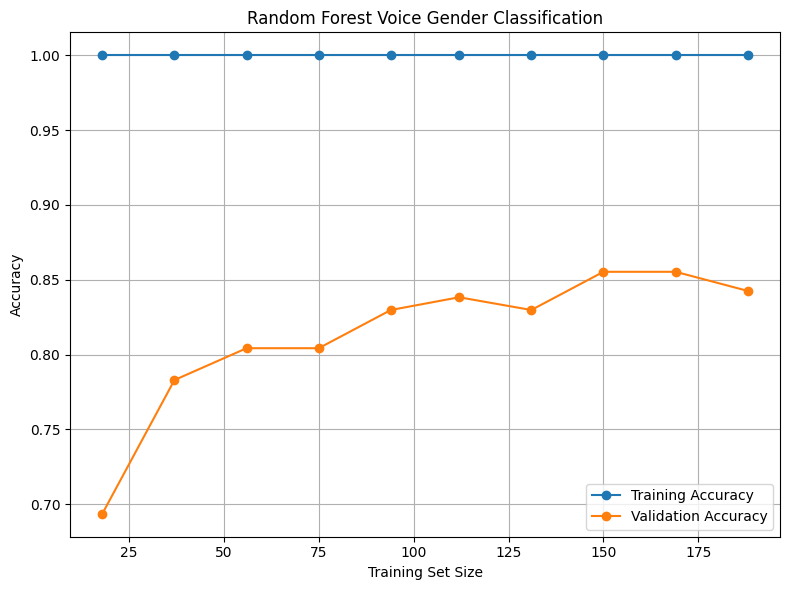

In [27]:
plot_learning_curve(model, X, y, title="Random Forest Voice Gender Classification")


Test model

In [29]:
model = joblib.load('voice_clssification_gender_model.pkl')


Prediction

In [35]:
features = extract_features('เสียงกูเอง.wav')
prediction = model.predict([features])[0]

print("Predicted gender:", "Male" if prediction == 0 else "Female")


Predicted gender: Male


แสดงConfusion Matrix

In [31]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Male", "Female"]))


              precision    recall  f1-score   support

        Male       0.91      0.95      0.93        21
      Female       0.96      0.92      0.94        26

    accuracy                           0.94        47
   macro avg       0.93      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47



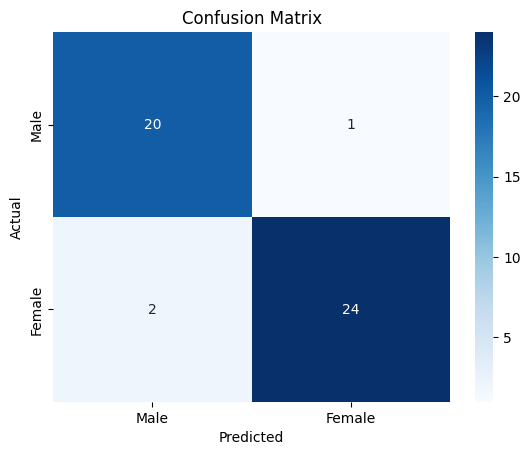

In [32]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Male", "Female"], yticklabels=["Male", "Female"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
